In [1]:
import pandas as pd
from utils.text import plot_wordclouds
import seaborn as sns

In [2]:
binary=False

# Carregando dados de análise

In [3]:
data_df = pd.read_csv("/home/kenzosaki/mestrado/data/tweetsentbr/tweetsentbr_test.csv", index_col=0)

In [4]:
id2label = {
    0: "neutro",
    1: "positivo",
    2: "negativo"
}

In [5]:
# Convertendo ids para labels para facilitar interpretação
data_df["label"] = data_df["label"].map(id2label)

In [6]:
data_df.head()

,label,text
2403,positivo,Começou o The Noite com o Charlie Hunnam
1349,negativo,"No twitter a 3ª feira é chata,pois todo mundo ..."
5422,neutro,Bial declamando os do garçom Conversa Com Bial
1262,neutro,AI MEU DEUS É AGORA Master Chef BR
5438,negativo,A Miriam só não roda pq eu acho que o tal sorv...


In [7]:
# Para focar a análise em apenas duas classes: positio e neutro
if binary:
    data_df = data_df[data_df["label"] != "neutro"]

# Definindo procedimento de pre-processamento de texto

Pipeline simples de pre-processamento de texto, incluindo: conversão para lower-case, remoção de stop-words, remoção de hashtags e lemmatização.

In [8]:
import spacy
nlp = spacy.load("pt_core_news_sm")

In [9]:
from typing import Iterable

def apply_preprocessing_pipeline(text: str) -> Iterable[str]:

    tokens = nlp(text)
    final_tokens = []

    for token in tokens:

        lemma = token.lemma_

        if token.is_stop: continue              # remoção de stop-words
        if token.is_punct: continue             # remoção de pontuação
        if len(lemma.strip()) == 0: continue    # ignorar tokens "vazios"
        if "@" in lemma: continue               # remoção simples de hashtags

        final_tokens.append(lemma.lower())
    
    return final_tokens

# Conversão dos textos para representações esparsas

In [10]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

In [11]:
params = {
    "max_features": 10000,                      # tamanho máximo de vocabulário
    "ngram_range": (1, 3),                      # ngrams 
    "tokenizer": apply_preprocessing_pipeline   # pipeline de pre processamento pelo spacy
}

In [12]:
vectorizer = CountVectorizer(**params)
# vectorizer = TfidfVectorizer(**params)

In [13]:
text_vectors = vectorizer.fit_transform(data_df["text"].values)

In [14]:
text_vectors.shape

(2463, 10000)

In [15]:
vectorizer.get_feature_names()[:10]

["'s",
 '+',
 '1',
 '1 globo',
 '1 globo esporte',
 '=',
 '`',
 'aaaaa',
 'aaaaaa',
 'aaaaaaa']

# Agrupamento usando K-means

In [16]:
from sklearn.cluster import KMeans
from tqdm import tqdm

In [17]:
# Quantidades de clusters para avaliar
n_clusters = list(range(2,11))
n_clusters

[2, 3, 4, 5, 6, 7, 8, 9, 10]

In [18]:
fitted_models = []
for k in tqdm(n_clusters):
    
    kmeans = KMeans(n_clusters=k, n_init=100, init='random', max_iter=500)
    kmeans.fit(text_vectors)

    fitted_models.append(kmeans)

100%|██████████| 9/9 [00:16<00:00,  1.84s/it]


# Avaliando silhueta dos agrupamentos gerados

In [19]:
from sklearn.metrics import silhouette_samples, silhouette_score
from yellowbrick.cluster.silhouette import silhouette_visualizer
import numpy as np
import matplotlib.pyplot as plt

In [20]:
sns.set(rc={'figure.figsize':(15,6)})

In [21]:
silhouettes = [silhouette_score(text_vectors, kmeans.labels_) for kmeans in fitted_models]
inertias = [kmeans.inertia_ for kmeans in fitted_models]

Text(0.5, 0, 'Number of clusters')

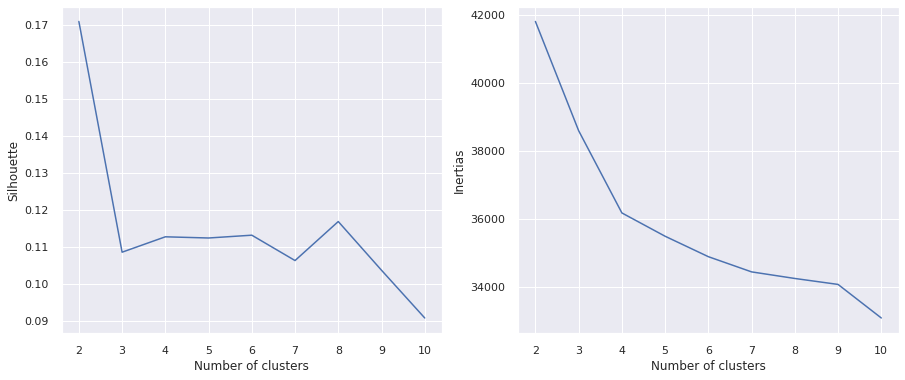

In [22]:
fig, axes = plt.subplots(1,2)

ax = sns.lineplot(x=n_clusters, y=silhouettes, ax=axes[0])
ax.set_ylabel("Silhouette")
ax.set_xlabel("Number of clusters")

ax = sns.lineplot(x=n_clusters, y=inertias, ax=axes[1])
ax.set_ylabel("Inertias")
ax.set_xlabel("Number of clusters")

In [23]:
# Escolhendo o modelo de maior silhueta mpedia para análise
kmeans = fitted_models[np.argmax(silhouettes)]

In [24]:
data_df["silhouette"] = silhouette_samples(text_vectors, kmeans.labels_)
data_df["cluster"] = kmeans.labels_

In [25]:
mean_silh = data_df["silhouette"].mean()

In [26]:
print(f"- EE: {kmeans.inertia_}")
print(f"- Mean silhouette: {mean_silh}")

- EE: 41798.486411948295
- Mean silhouette: 0.17093200862374405


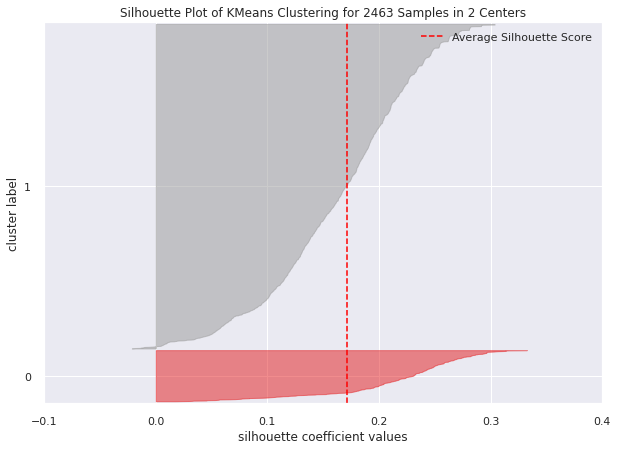

/home/kenzosaki/anaconda3/envs/transformers/lib/python3.7/site-packages/sklearn/base.py:213: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


SilhouetteVisualizer(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x7febd5658a90>,
                     model=None)

In [27]:
sns.set(rc={'figure.figsize':(10,7)})
silhouette_visualizer(
    kmeans,
    X=text_vectors.todense(),
    y=data_df["label"].values,
    is_fitted=True
)

# Comparação entre clusters

Comparando pares de clusters, com relação as classes (positivo, neutro ou negativo) e palavras frequentes.

In [28]:
cluster_pair = (0, 1)

In [29]:
c0_df = data_df[data_df["cluster"] == cluster_pair[0]]
c1_df = data_df[data_df["cluster"] == cluster_pair[1]]

# Distribuição de classes por cluster

In [30]:
order = ["positivo", "negativo"] if binary else \
        ["positivo", "neutro", "negativo"]

Text(0.5, 0, 'Cluster 1')

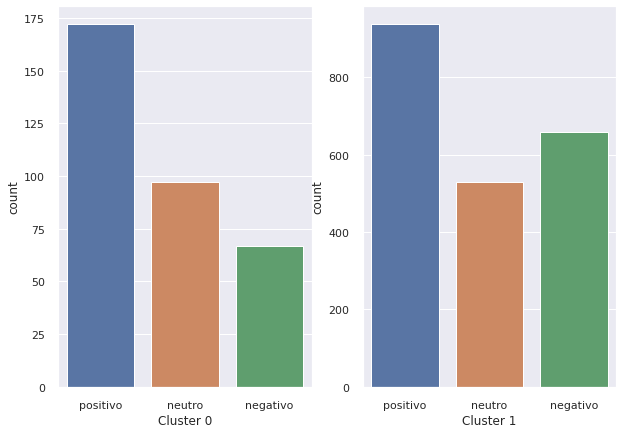

In [31]:
fig, axes = plt.subplots(1,2)

sns.countplot(data=c0_df, x="label", ax=axes[0], order=order)
axes[0].set_xlabel(f"Cluster {cluster_pair[0]}")
sns.countplot(data=c1_df, x="label", ax=axes[1], order=order)
axes[1].set_xlabel(f"Cluster {cluster_pair[1]}")

## Wordclouds por cluster

Gerando nuvens de palavras para cluster do par em análise.

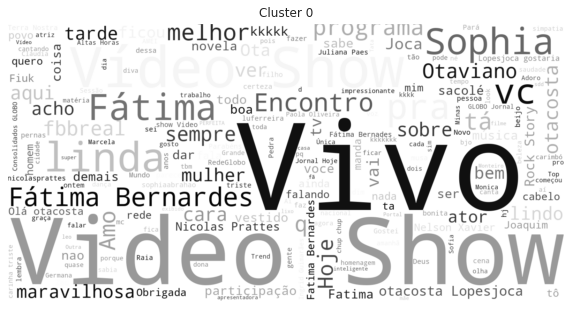

In [32]:
plot_wordclouds(
    text=" ".join(c0_df["text"].values.tolist()),
    title=f"Cluster {cluster_pair[0]}",
    colormap="binary", 
    background_color='white',
    max_words=200,
    width=1600, height=800
)

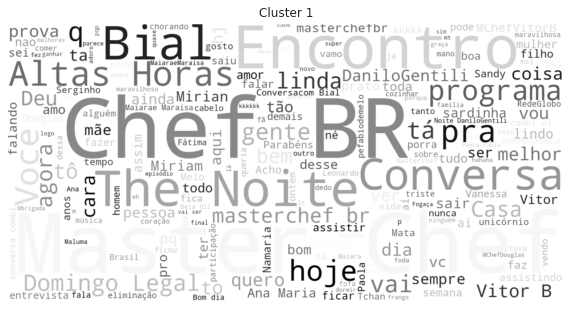

In [33]:
plot_wordclouds(
    text=" ".join(c1_df["text"].values.tolist()),
    title=f"Cluster {cluster_pair[1]}",
    colormap="binary", 
    background_color='white',
    max_words=200,
    width=1600, height=800
)

# Visualizando exemplos de maior silhueta por cluster

In [34]:
cluster = 1

In [35]:
c_df = data_df[data_df["cluster"] == cluster]

In [36]:
pd.set_option('max_colwidth', None)
c_df.sort_values(by="silhouette", ascending=False).head(10)

,label,text,silhouette,cluster
5446,neutro,Vaiii Anaaa Master Chef BR,0.303537,1
3654,negativo,Galinhadx desconstruídx Master Chef BR,0.303537,1
3486,neutro,Vai começaaaaar Master Chef Br,0.303537,1
240,positivo,Depois tenho que ver Master Chef BR,0.303537,1
409,negativo,Master Chef BR QUE CUUUUU,0.303537,1
3895,positivo,Master Chef BR boa Anaaaa @MChefAnaLuiza 😍,0.292444,1
407,negativo,Tô bem chatiada Master Chef BR @masterchefbr @MChefVitorB,0.292398,1
6144,positivo,valter é muito fera ! Master Chef BR,0.291578,1
3014,positivo,master Chef BR mal posso esperar ...,0.291493,1
1175,neutro,Master Chef BR muito bombeiros,0.291403,1
